<a href="https://colab.research.google.com/github/JPtheOne/GAN_Celebs/blob/main/GAN_171657.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras implementation 




##Installing libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Veryfing path

In [ ]:
import os

folder_path = '/content/drive/MyDrive/Celeb10k/'
image_files = os.listdir(folder_path)
print(f'Number of images: {len(image_files)}')


Number of images: 10000


In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    folder_path, label_mode=None, image_size=(64, 64), batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


## Creating dataset

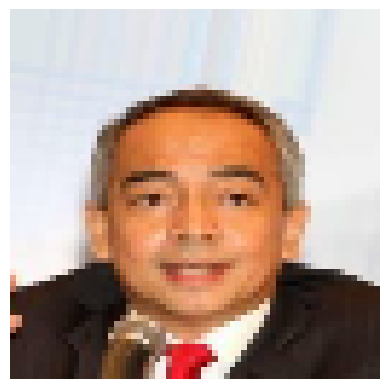

In [ ]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Defining discriminator agent

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## Defining generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

## Creating training sessions

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Saving and indexing results

In [ ]:
import os
import numpy as np

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, save_dir="generated_images"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        grid_size = int(np.sqrt(self.num_img))
        grid_height = grid_width = 64 * grid_size
        grid = np.zeros((grid_height, grid_width, 3))
        
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) * 127.5
        generated_images = generated_images.numpy().astype(np.uint8)
        
        for i, img in enumerate(generated_images):
            x = (i % grid_size) * 64
            y = (i // grid_size) * 64
            grid[y:y + 64, x:x + 64] = img

        img_path = os.path.join(self.save_dir, f"image_grid_epoch_{epoch:03d}.png")
        keras.preprocessing.image.save_img(img_path, grid)


## Instancing trainings

In [ ]:
epochs = 500 # In practice, use ~100 epochs
num_img = 16

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img, latent_dim=latent_dim, save_dir="generated_images")]
)


Epoch 1/500
313/313 [==============================] - 13s 28ms/step - d_loss: 0.6100 - g_loss: 1.0007
Epoch 2/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6243 - g_loss: 0.9917
Epoch 3/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6190 - g_loss: 0.9890
Epoch 4/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6126 - g_loss: 1.0001
Epoch 5/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6194 - g_loss: 1.0043
Epoch 6/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6118 - g_loss: 1.0039
Epoch 7/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6216 - g_loss: 1.0118
Epoch 8/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6193 - g_loss: 0.9931
Epoch 9/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.6207 - g_loss: 1.0005
Epoch 10/500
313/313 [==============================] - 9s 28ms/step - d_loss: 0.

## GIF Creator

In [20]:
import imageio

def create_gif(epochs, save_dir, gif_filename):
    # Collect the image file names for each epoch
    filenames = []
    for i in range(1, epochs):
        filenames.append(os.path.join(save_dir, f"image_grid_epoch_{i:03d}.png"))

    # Create the GIF using imageio
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_filename, images, fps=2)

# Example usage:
create_gif(500, "generated_images", "generated_images.gif")


<ipython-input-20-c341745b77fa>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
